In [1]:
import os.path

import matplotlib.pyplot as plt
import math
import pathlib

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import trange, tqdm

import score_based_sampling.models as models
from score_based_sampling.train_score_model import train_score_model, estimate_max_distance_in_dataset

In [2]:
gpu_id = 0
device = torch.device(f'cuda:{gpu_id}')

#Load data
train_bs = 128
val_bs = 512


dataset_dir = 'datasets/MNIST'
p = pathlib.Path(dataset_dir).mkdir(parents=True, exist_ok=True)

train_dataset = torchvision.datasets.MNIST(dataset_dir, train=True, download=True,
                           transform=torchvision.transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True)


val_dataset = torchvision.datasets.MNIST(dataset_dir, train=False, download=True,
                           transform=torchvision.transforms.ToTensor())
val_loader = DataLoader(val_dataset, batch_size=val_bs, shuffle=False)

In [3]:
#Noise scales
N_sigma_estimation_samples = min(10_000, len(train_dataset))
sigma_estimation_samples = torch.zeros((N_sigma_estimation_samples, 1, 28, 28))
collected_samples = 0

train_iter = iter(train_loader)
while collected_samples < N_sigma_estimation_samples:
    data = next(train_iter)[0]
    samples_to_collect_from_batch = min(len(data), N_sigma_estimation_samples - collected_samples)
    data = data[:samples_to_collect_from_batch]
    sigma_estimation_samples[collected_samples:(collected_samples+samples_to_collect_from_batch)] = data

    collected_samples += samples_to_collect_from_batch


max_sigma = estimate_max_distance_in_dataset(sigma_estimation_samples.view(N_sigma_estimation_samples, -1))
min_sigma_target = 0.01
N_noise_scales = 250

#geometric series with common ratio gamma
gamma = (min_sigma_target / max_sigma) ** (1 / (N_noise_scales - 1))
sigmas = max_sigma * gamma ** (torch.arange(0, N_noise_scales))
sigmas = sigmas.to(device)
min_sigma = sigmas[-1]

print(f'Max sigma {max_sigma:.3f} - Min Sigma {min_sigma:.3f} - Num scales {N_noise_scales} - Gamma {gamma:.3f}')

Max sigma 15.982 - Min Sigma 0.010 - Num scales 250 - Gamma 0.971


In [4]:
#load our model
epochs = 200
lr = 0.001
optim = 'adam'

modelname = 'ncsnv2'

if modelname == 'unet':
    model = models.get_MNIST_UNet(sigmas)
elif modelname == 'ncsnv2':
    model = models.get_MNIST_NCSNv2(sigmas)
else:
    raise NotImplemented

model_chkpt_filename = f'mnist_{modelname}_{N_noise_scales}.pth'
if os.path.isfile(model_chkpt_filename):
    print('Loading model checkpoint from file')
    model.load_state_dict(torch.load(model_chkpt_filename))
    model.to(device)
else:
    model.to(device)
    print('Starting score net training...')
    train_score_model(model, sigmas, train_loader, lr, epochs, device, optim=optim, val_loader=val_loader)
    torch.save(model.state_dict(), model_chkpt_filename)
    print('Training done')

Starting score net training...
Epoch 0 - Avg train loss 403.3982849121094
Val loss 391.946533203125
Epoch 1 - Avg train loss 387.794921875
Val loss 368.784423828125
Epoch 2 - Avg train loss 308.7484130859375
Val loss 279.36328125
Epoch 3 - Avg train loss 268.6764221191406
Val loss 289.85467529296875
Epoch 4 - Avg train loss 253.82504272460938
Val loss 245.0906982421875
Epoch 5 - Avg train loss 243.81289672851562
Val loss 241.29115295410156
Epoch 6 - Avg train loss 241.0709686279297
Val loss 230.50640869140625
Epoch 7 - Avg train loss 229.1835479736328
Val loss 228.08120727539062
Epoch 8 - Avg train loss 227.80726623535156
Val loss 219.05279541015625
Epoch 9 - Avg train loss 220.03269958496094
Val loss 228.14109802246094
Epoch 10 - Avg train loss 226.57553100585938
Val loss 211.39450073242188
Epoch 11 - Avg train loss 219.55264282226562
Val loss 220.1234130859375
Epoch 12 - Avg train loss 219.23519897460938
Val loss 215.0110626220703
Epoch 13 - Avg train loss 216.1722412109375
Val loss 

In [5]:
#Langevin samples - Multiple Noise Scales
#Stepsize selection using Technique 4

def calc_eq4(eps):
    first_factor = (1 - eps / min_sigma**2)**(2*N_noise_scales)
    inner_denom = min_sigma**2 - (min_sigma**2) * (1 - eps / min_sigma**2)**2
    sec_factor = gamma**2 - (2*eps) / inner_denom
    third_term = (2*eps) / inner_denom
    return first_factor * sec_factor + third_term

print(f'Eq 4 0: {calc_eq4(1e-10)} - Gamma sqr {gamma**2}')

eps_search = torch.linspace(1e-10, 1e3, 1_000_000, device=device)
eps_eq4_vals = calc_eq4(eps_search)
best_eps_idx = torch.argmin(torch.abs(1 -  eps_eq4_vals))
eps = eps_search[best_eps_idx]
eq4_val_best_eps = eps_eq4_vals[best_eps_idx]

print(f'Epsilon Langevin {eps} - Achieved EQ4 value {eq4_val_best_eps}')

eps = 1e-4

Eq 4 0: 0.9424909949302673 - Gamma sqr 0.9424711465835571
Epsilon Langevin 1.000000013351432e-10 - Achieved EQ4 value 0.9424909949302673


In [6]:
#https://abdulfatir.com/blog/2020/Langevin-Monte-Carlo/
#https://en.wikipedia.org/wiki/Stochastic_gradient_Langevin_dynamics
num_samples = 25
sampling_steps_per_noise_scale = 5
ns_samples = torch.rand((num_samples, 1, 28, 28), device=device)

model.eval()
with torch.no_grad():
    for sigma_idx, sigma in tqdm(enumerate(sigmas)):
        noise_scale_idcs = sigma_idx * torch.ones(num_samples, dtype=torch.long, device=device)
        alpha = eps * (sigma / min_sigma)**2
        for _ in range(sampling_steps_per_noise_scale):
            score = model(ns_samples, noise_scale_idcs)
            noise = torch.randn_like(ns_samples, device=device)
            #print(f'score norm = {torch.sum(((alpha * score)**2).view(num_samples,-1), dim=1).mean():.3f}')
            #print(f'noise norm = {torch.sum(((math.sqrt(2 * alpha) * noise)**2).view(num_samples,-1), dim=1).mean():.3f}')
            #print(f'alpha = {alpha:.3f} - noise alpha {math.sqrt(2 * alpha)}')
            ns_samples = ns_samples + alpha * score + alpha * noise #math.sqrt(2 * alpha) * noise

ns_samples = ns_samples.detach().cpu()

250it [00:24, 10.15it/s]


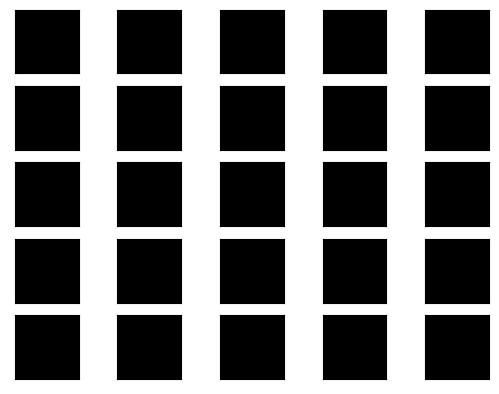

In [7]:
N_cols = int(math.ceil(math.sqrt(num_samples)))
N_rows = int(math.ceil(num_samples / N_cols))

fig, axs = plt.subplots(N_rows, N_cols)
for i in range(N_rows):
    for j in range(N_cols):
        lin_Idx = i * N_cols + j
        img = ns_samples[lin_Idx]
        img = torch.cat([img,img,img])
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[i, j].imshow(np.asarray(img))
        axs[i, j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])